# Vehicle Detection
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Creating a great writeup:
---
A great writeup should include the rubric points as well as your description of how you addressed each point.  You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references.  You should include images in your writeup to demonstrate how your code works with examples.  

All that said, please be concise!  We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :). 

You can submit your writeup in markdown or use another method and submit a pdf instead.

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

**As an optional challenge** Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

**If you're feeling ambitious** (also totally optional though), don't stop there!  We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!


# Solution

## Classifer

### Transfer learning using Pretrained VGGNet
We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg.

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from *Deep learning nanodegree foundation*.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

VGG16 Parameters: 553MB [00:09, 55.9MB/s]                              


### ConvNet Codes
Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.
Here we're using the vgg16 module from tensorflow_vgg. The network takes images of size $244 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from the source code:
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
So what we want are the values of the first fully connected layer, after being ReLUd (self.relu6). To build the network, we use
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
This creates the vgg object, then builds the graph with vgg.build(input_). Then to get the values from the layer,
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)

In [2]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

print("tensorflow version", tf.__version__)

tensorflow version 1.2.0


#### Import Data

In [10]:
import zipfile
import os

dataset_folder_path = 'training_data'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
#
if not isdir(dataset_folder_path):
    os.mkdir(dataset_folder_path)
        
# vehicles data
if not isfile(dataset_folder_path + '/vehicles.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Vehicle Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip',
            dataset_folder_path + '/vehicles.zip',
            pbar.hook)

if not isdir(dataset_folder_path + '/vehicles'):
    with zipfile.ZipFile(dataset_folder_path + '/vehicles.zip') as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        zip_ref.close()

# non-vehicles data
if not isfile(dataset_folder_path + '/non-vehicles.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Non-Vehicle Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip',
            dataset_folder_path + '/non-vehicles.zip',
            pbar.hook)

if not isdir(dataset_folder_path + '/non-vehicles'):
    with zipfile.ZipFile(dataset_folder_path + '/non-vehicles.zip') as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        zip_ref.close()

In [11]:
import glob

cars = glob.glob('training_data/vehicles/**/*.png', recursive=True)
not_cars = glob.glob('training_data/non-vehicles/**/*.png', recursive=True)

nb_cars = len(cars)
nb_not_cars = len(not_cars)

Number of vehicles 8792
Number of non-vehicles 8968


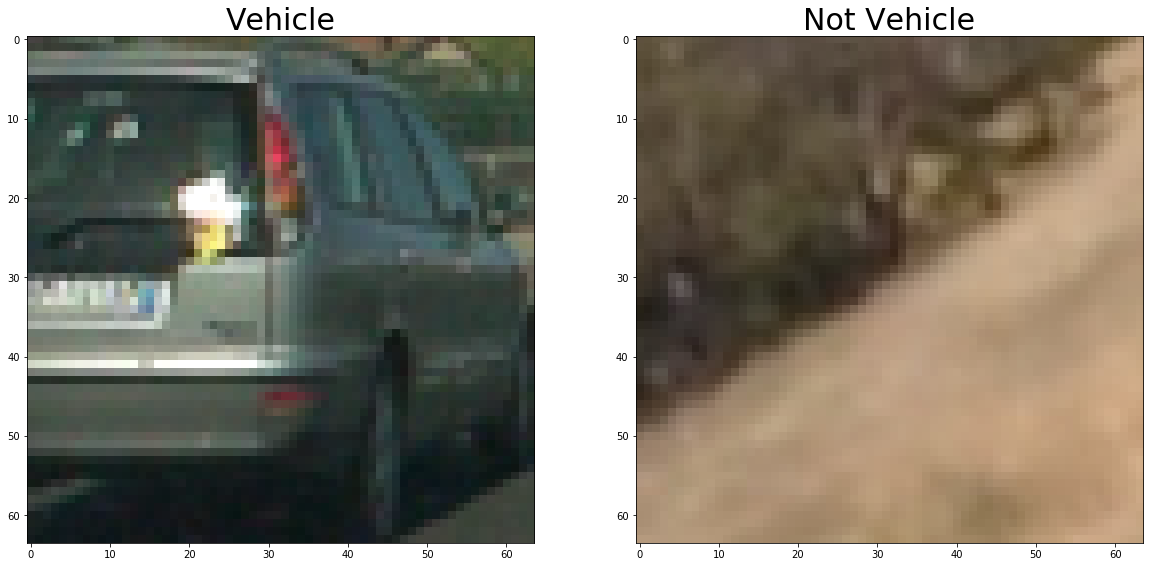

In [12]:
print("Number of vehicles", len(cars))
print("Number of non-vehicles", len(not_cars))

idx1 = np.random.randint(nb_cars)
idx2 = np.random.randint(nb_not_cars)
img1 = cv2.imread(cars[idx1])
img2 = cv2.imread(not_cars[idx2])

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title('Vehicle', fontsize=30)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title('Not Vehicle', fontsize=30)

In [13]:
# Generate features
files = cars + not_cars

# Generate classes
labels = np.vstack((np.ones((nb_cars, 1), dtype=np.int8),
                   np.zeros((nb_not_cars, 1), dtype=np.int8)))

#### Training VGG network in batches
The input for VGG network is `224x224x3`

In [14]:
batch_size = 10
codes_list = []
batch = []

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
        
    for i, file in enumerate(files, 1):
        img = utils.load_image(file)
        batch.append(img.reshape((1, 224, 224, 3)))
        
        # Running the batch through the network to get the codes
        if i % batch_size == 0 or i == len(files):
            images = np.concatenate(batch)
            feed_dict = {input_: images}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
            
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
                
            # Reset to start building the next batch
            batch = []
            print('{} images processed'.format(i))
        

/home/carnd/CarND-Vehicle-Detection/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
(10, 224, 224, 3)
10 images processed
(10, 224, 224, 3)
20 images processed
(10, 224, 224, 3)
30 images processed
(10, 224, 224, 3)
40 images processed
(10, 224, 224, 3)
50 images processed
(10, 224, 224, 3)
60 images processed
(10, 224, 224, 3)
70 images processed
(10, 224, 224, 3)
80 images processed
(10, 224, 224, 3)


KeyboardInterrupt: 

In [ ]:
img = utils.load_image(files[0])
print(img.shape)
plt.imshow(img)

#### Check Point

In [ ]:
import pickle

# Write codes to file
pickle.dump((codes, labels), open('preprocess_data.p', 'wb'))

### Building the Classifier

In [ ]:
import pickle

(codes, labels) = pickle.load(open('preprocess_data.p', mode='rb'))

#### Data Preparation
Create validation/test sets

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [ ]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

### Classifier layers

With the `codes` and `labels` loaded, build the classifier. Consider the codes as your inputs, each of them are `4096D` vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [ ]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]], name="inputs")
labels_ = tf.placeholder(tf.int64, shape=[None, labels.shape[1]], name="labels")

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Training

In [ ]:
def get_batches(x, y, n_batches=10):
    batch_size = len(x) // n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        if ii != (n_batches-1) * batch_size:
            X, Y = x[ii: ii+batch_size], yy[ii: ii+batch_size]
        else:
            X, Y = x[ii:], y[ii:]
        yield X, Y

In [ ]:
epochs = 10
iteration = 0
saver = tf.train.Saver()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                   labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                 "Iteration: {}".format(iteration),
                 "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                       labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                     "Iteration: {}".format(iteration),
                     "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/vehicles.ckpt")
        

### Testing

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
           labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

In [ ]:
idx = np.random.int(len(test_x))
test_img_path = test_x[idx]
test_img = imread(test_img_path)
plt.imshow(test_img)

In [ ]:
# Run this cell if you don't have a vgg graph built
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

In [ ]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))
    
    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
    
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

In [ ]:
plt.imshow(test_img)

In [ ]:
plt.barh(np.arange(2), prediction)
_ = plt.yticks(np.arange(2), ["Vehicle", "Non-Vehicle"])

## Checkpoint

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

print("tensorflow version", tf.__version__)

In [ ]:
# Build VGG graph
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

In [ ]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))
    
    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
    
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()